## Nous allons tester nos modèles sur des images en live

In [37]:
from torchvision import transforms
# Gestion des fichiers et système
import os
import json
import pickle
from pathlib import Path
from glob import glob
import clip
import numpy as np

# Deep Learning (PyTorch)
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Traitement d'images et Visualisation
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
# Machine Learning classique
from sklearn.model_selection import train_test_split

import torch.nn.functional as F


In [40]:
def inference(model, filespath, idx_to_class, device=None):
    """
    Effectue une inférence sur toutes les images d'un dossier et affiche
    image + scores softmax + prédiction finale avec confiance.

    Args:
        model (nn.Module): modèle PyTorch entraîné
        filespath (str): chemin vers le dossier contenant les images
        idx_to_class (dict): mapping index -> nom de classe
        device (torch.device, optional)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    # Transform EXACTEMENT comme à l'entraînement
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])

    image_files = [
        f for f in os.listdir(filespath)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]

    if len(image_files) == 0:
        print("Aucune image trouvée dans le dossier.")
        return

    for filename in image_files:
        img_path = os.path.join(filespath, filename)

        # --- Chargement image ---
        image_pil = Image.open(img_path).convert("RGB")
        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        # --- Inférence ---
        with torch.no_grad():
            logits = model(image_tensor)          # [1, num_classes]
            probs = torch.softmax(logits, dim=1)[0]  # [num_classes]

        probs_np = probs.cpu().numpy()

        # --- Classe prédite ---
        pred_idx = probs.argmax().item()
        pred_class = idx_to_class[pred_idx]
        confidence = probs[pred_idx].item()

        # --- Affichage texte ---
        print("\n========================================")
        print(f"Image: {filename}")
        print("Softmax results:")
        for i, score in enumerate(probs_np):
            print(f"{score*100:.4f} : {idx_to_class[i]}")

        print(f"\nPREDICTION FINALE : {pred_class.upper()} ({confidence*100:.2f}%)")

        # --- Affichage image + confiance ---
        plt.figure(figsize=(6, 6))
        plt.imshow(image_pil)
        plt.axis("off")

        plt.title(
            f"{pred_class.upper()} – confiance : {confidence*100:.1f}%",
            fontsize=14,
            color="green" if confidence > 0.5 else "orange"
        )

        # Barre de confiance visuelle
        plt.text(
            0.5, -0.08,
            "█" * int(confidence * 20),
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
            fontsize=12,
            color="green"
        )

        plt.show()
def test_clip_folder(folder_path,
                     clip_model="RN50x4",
                     saliency_layer="layer4",
                     blur=False,
                     exts=(".jpg", ".jpeg", ".png")):
    """
    Tester clip for all images in folder
    """
 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(clip_model, device=device, jit=False)
 
    # Emotion prompts
    emotions_prompt = {
        "neutral": "a neutral, expressionless face",
        "angry": "an angry, furious facial expression",
        "disgust": "a disgusted, repulsed face",
        "fear": "a scared, terrified person",
        "happy": "a happy, smiling face",
        "sad": "a sad, sorrowful face",
        "surprise": "a surprised, shocked facial expression"
    }
 
    ordered_emotions = ["angry", "disgust", "fear",
                        "happy", "neutral", "sad", "surprise"]
 
    prompts = [f"a photo of {emotions_prompt[e]}" for e in ordered_emotions]
    text_inputs = clip.tokenize(prompts).to(device)
 
    # Iterate over images in folder
    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(exts):
            continue
 
        image_path = os.path.join(folder_path, filename)
        print(f"\n Processing: {filename}")
 
        # Load image
        image_raw = Image.open(image_path).convert("RGB")
        image_input = preprocess(image_raw).unsqueeze(0).to(device)
        image_np = load_image(image_path, model.visual.input_resolution)
 
        # Forward pass
        logits_per_img, _ = model(image_input, text_inputs)
 
        # Print scores
        for i, score in enumerate(logits_per_img[0]):
            print(f"{score.item():.4f} : {ordered_emotions[i]}")
 
        # Best emotion
        best_idx = logits_per_img.argmax(dim=-1).item()
        best_emotion = ordered_emotions[best_idx]
        print(f"Predicted emotion: {best_emotion}")
 
        
        best_tokens = text_inputs[best_idx].unsqueeze(0)
 
        attn_map = gradCAM(
            model.visual,
            image_input,
            model.encode_text(best_tokens).float(),
            getattr(model.visual, saliency_layer)
        )
 
        attn_map = attn_map.squeeze().detach().cpu().numpy()
        viz_attn(image_np, attn_map, blur)

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x
    
# https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()
    
def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    if input.grad is not None:
        input.grad.data.zero_()


    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        output = model(input)
        output.backward(target)
        grad = hook.gradient.float()
        act = hook.activation.float()
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        gradcam = torch.clamp(gradcam, min=0)

    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


#### Charger les modèles entrainés

In [17]:
from models import ResNet16_96, EmotionCNN
import torch
#clip_model = clip_model

#CNN
model_scratch = EmotionCNN(num_classes=7)
model_scratch.load_state_dict(torch.load("best_emotion_cnn.pt")["model_state_dict"])

#RESNET
model_ft = ResNet16_96(num_classes=7)
model_ft.load_state_dict(torch.load("best_model_resnet.pth")["model_state_dict"])

emotion_Dict = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}
idx_to_class = {v: k for k, v in emotion_Dict.items()}

/tmp/ipykernel_828/1692743769.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_scratch.load_state_dict(torch.load("best_emotion_cnn.pt")["model_state_dict"])
/tmp/i

# Test de CLIP ( Zero-shot)


 Processing: happy.jpg
31.9062 : angry
30.5469 : disgust
33.0625 : fear
37.0625 : happy
32.1875 : neutral
31.5312 : sad
33.6875 : surprise
Predicted emotion: happy


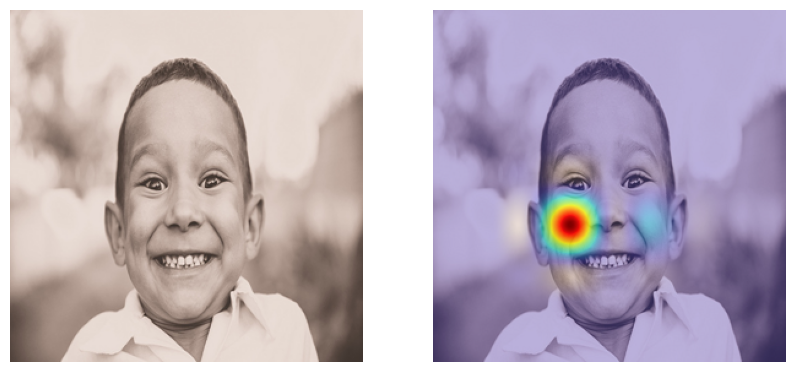


 Processing: test_abdel_angry.jpg
36.9688 : angry
36.7188 : disgust
32.9375 : fear
31.2344 : happy
38.2812 : neutral
34.8750 : sad
35.7500 : surprise
Predicted emotion: neutral


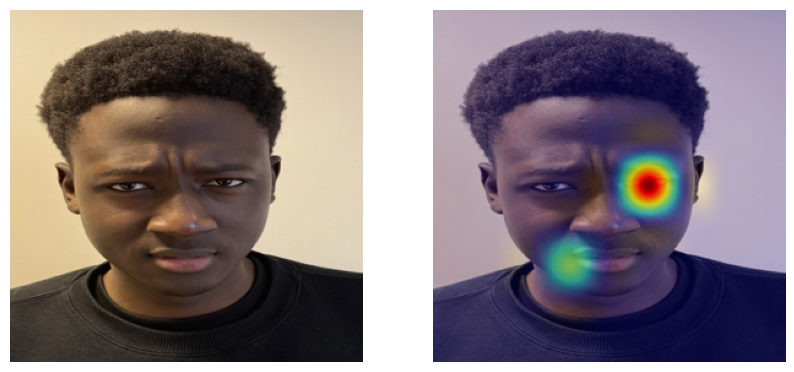


 Processing: test_abdel_happy.jpg
29.5625 : angry
31.2812 : disgust
29.9531 : fear
33.5625 : happy
33.3125 : neutral
29.7656 : sad
30.1406 : surprise
Predicted emotion: happy


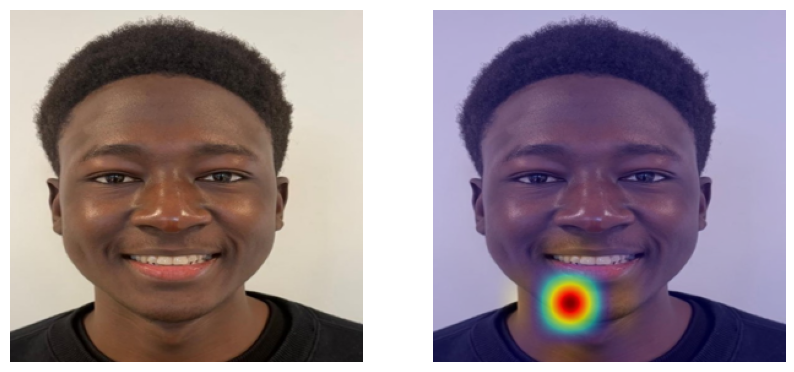


 Processing: test_abdel_neutral.jpg
31.0469 : angry
31.6406 : disgust
29.4844 : fear
30.4062 : happy
34.6562 : neutral
31.0312 : sad
30.2812 : surprise
Predicted emotion: neutral


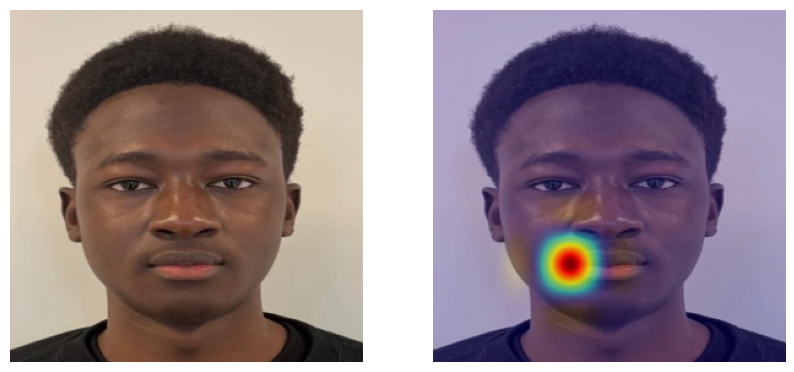


 Processing: test_angry.jpg
35.5625 : angry
34.5938 : disgust
33.2188 : fear
31.9688 : happy
33.7188 : neutral
35.2500 : sad
34.4375 : surprise
Predicted emotion: angry


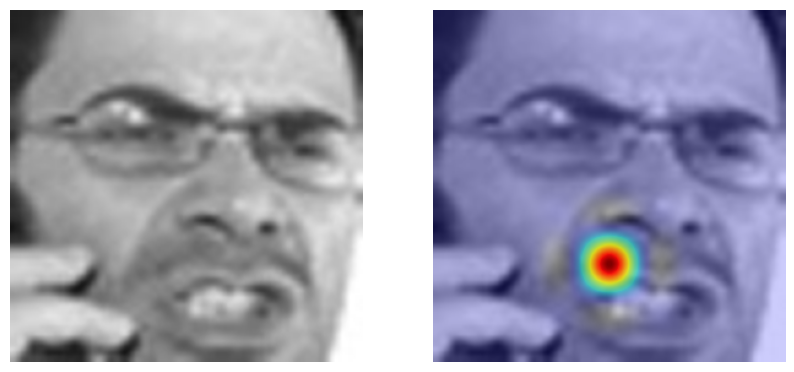

In [41]:
test_clip_folder(
    folder_path="/root/myhomedir/facialemotionrecognition/image_live_test"
)

# Test de CNN (From Scratch)


Image: test_angry.jpg
Softmax results:
23.5742 : angry
8.4534 : disgust
15.5193 : fear
3.6556 : happy
20.3628 : neutral
26.3257 : sad
2.1091 : surprise

PREDICTION FINALE : SAD (26.33%)


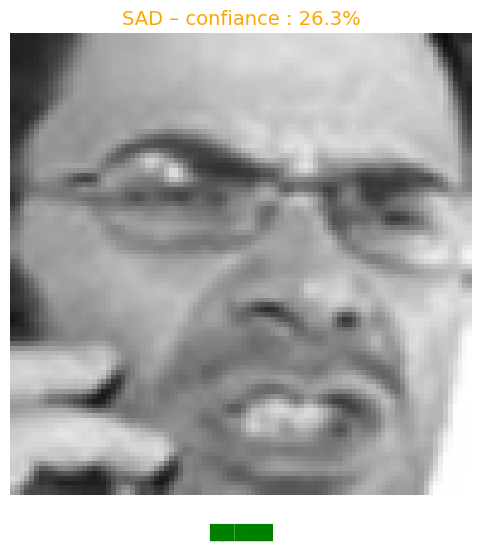


Image: happy.jpg
Softmax results:
4.2347 : angry
3.9151 : disgust
5.9991 : fear
28.8201 : happy
29.2967 : neutral
11.6721 : sad
16.0622 : surprise

PREDICTION FINALE : NEUTRAL (29.30%)


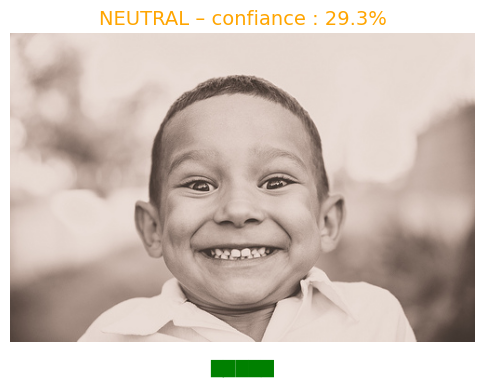


Image: test_abdel_happy.jpg
Softmax results:
4.6475 : angry
2.9003 : disgust
6.9519 : fear
9.4579 : happy
31.1948 : neutral
18.1515 : sad
26.6960 : surprise

PREDICTION FINALE : NEUTRAL (31.19%)


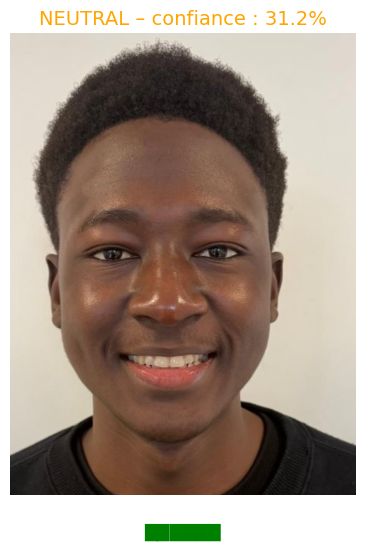

In [14]:
inference(
    model=model_scratch,
    filespath="/root/myhomedir/facialemotionrecognition/image_live_test",
    idx_to_class=idx_to_class
)

# Test de ResNet ( Fine-Tuning)


Image: test_angry.jpg
Softmax results:
70.2530 : angry
12.6630 : disgust
2.7582 : fear
0.3020 : happy
9.1459 : neutral
4.8506 : sad
0.0273 : surprise

PREDICTION FINALE : ANGRY (70.25%)


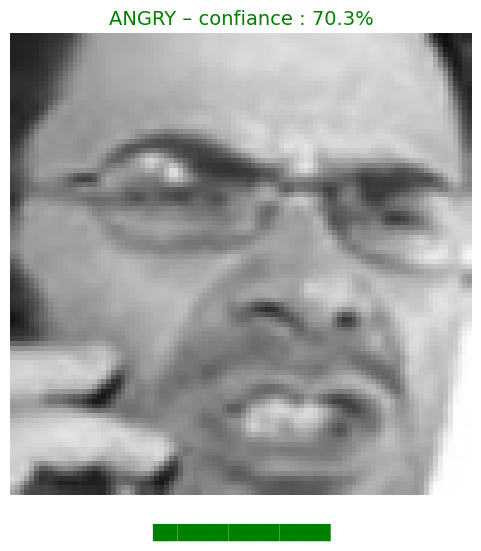


Image: happy.jpg
Softmax results:
3.0679 : angry
0.1022 : disgust
0.2835 : fear
0.0815 : happy
33.5469 : neutral
1.6661 : sad
61.2519 : surprise

PREDICTION FINALE : SURPRISE (61.25%)


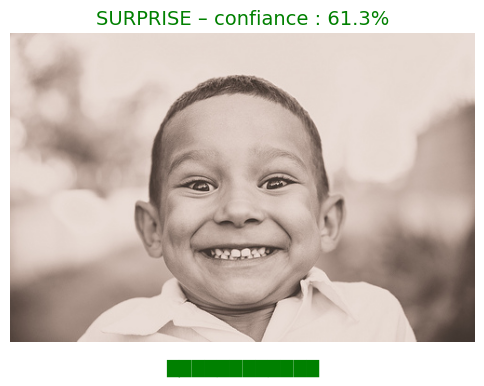


Image: test_abdel_happy.jpg
Softmax results:
6.2777 : angry
0.2005 : disgust
0.2844 : fear
0.0198 : happy
29.3792 : neutral
4.0593 : sad
59.7791 : surprise

PREDICTION FINALE : SURPRISE (59.78%)


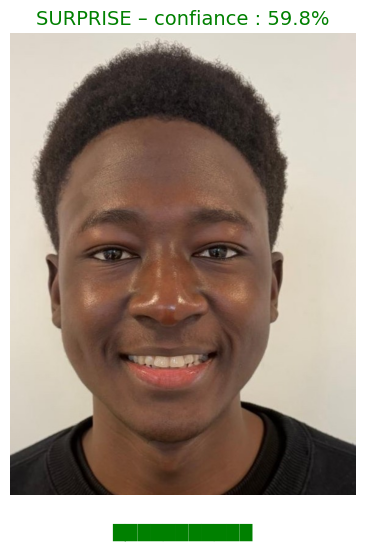

In [11]:
inference(
    model=model_ft,
    filespath="/root/myhomedir/facialemotionrecognition/image_live_test",
    idx_to_class=idx_to_class
)